In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [6]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.manager import SwarmManager
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo

from backtester.positionsizing import PositionSizingBase
import pandas as pd
import numpy as np
import scipy

In [7]:

from strategies.strategy_macross_with_trail import StrategyMACrossTrail

## Script settings

In [13]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyMACrossTrail,
        'exo_name': '../../mat/strategy_270225.mat',       
        'opt_params': [
                #OptParam(name, default_value, min_value, max_value, step)
                OptParamArray('Direction', [-1]),
                OptParam('SlowMAPeriod', 20, 10, 90, 10),
                OptParam('FastMAPeriod', 2, 2, 20, 2),
                OptParam('MedianPeriod', 5, 2, 20, 2)
            ],
    },    
    'swarm': {
        'members_count': 2,
        'ranking_function': SwarmRanker.highestreturns_universal,
        'ranking_params': {
            # 'ranking_type' - global ranking mode
            # 'returns' - main ranking function based on highest returns N days
            # 'relstr_ratio' - relative strength (equity / MA(equity)) (has negative equity BUG!)
            # 'relstr_delta' - relative strength (equity - MA(equity))            
            'ranking_type': 'relstr_ratio',
            
            # Used for 'ranking_type' = 'relstr'
            'ranking_relstr_ma_period': 14,
            'ranking_relstr_upperbound': 2.0,
            'ranking_relstr_lowerbound': 0.99,
            
            # Used for 'ranking_type' = 'returns'
            # Ranking function exta parameters (main ranking metric period)
            'ranking_returns_period': 14,
            
            # Ignoring all members which equity less than it's MovingAverage({ignore_eqty_less_ma_period})
            'ignore_eqty_less_ma': True,                    # Comment the line to turn off
            'ignore_eqty_less_ma_period': 90,               # Equity Moving Average period
            
            # Ignoring all members which equity less than TOP swarmmembers quantile
            #'ignore_eqty_less_top_quantile': True,          # Comment the line to turn off
            'ignore_eqty_less_top_quantile_threshold': 0.9,  # Ignore all members less than 0.9 quantile
            
            # Ignoring all swarm members wich have negative MA slope 
            #'ignore_eqty_with_negative_ma_slope': True,     # Comment the line to turn off
            'ignore_eqty_with_negative_ma_period': 90,      # Period of moving average
            'ignore_eqty_with_negative_ma_slope_period': 5, # Slope lookback filter = MA-MA[-slope_lookback] <= 0
            
            # Ignoring all swarm members when the change of AvgSwarm equity is negative
            #'ignore_if_avg_swarm_negative_change': True,      # Comment the line to turn off
            'ignore_if_avg_swarm_negative_change_period': 90, # AvgSwarm change period 
            
        },
        'rebalance_time_function': SwarmRebalance.every_monday,    
        # SwarmFilter.swingpoint_daily - original TMQR Swingpoint logics from Matlab
        # SwarmFilter.volatility_chandelier - Alex's volatility based logic (old name: SwarmFilter.swingpoint_threshold)
        'global_filter_function': SwarmFilter.volatility_chandelier,
        'global_filter_params': {
            'up_factor': 5.0,
            'down_factor': 15.0,
            'period': 5,
        },      
    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [14]:
smgr = SwarmManager(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

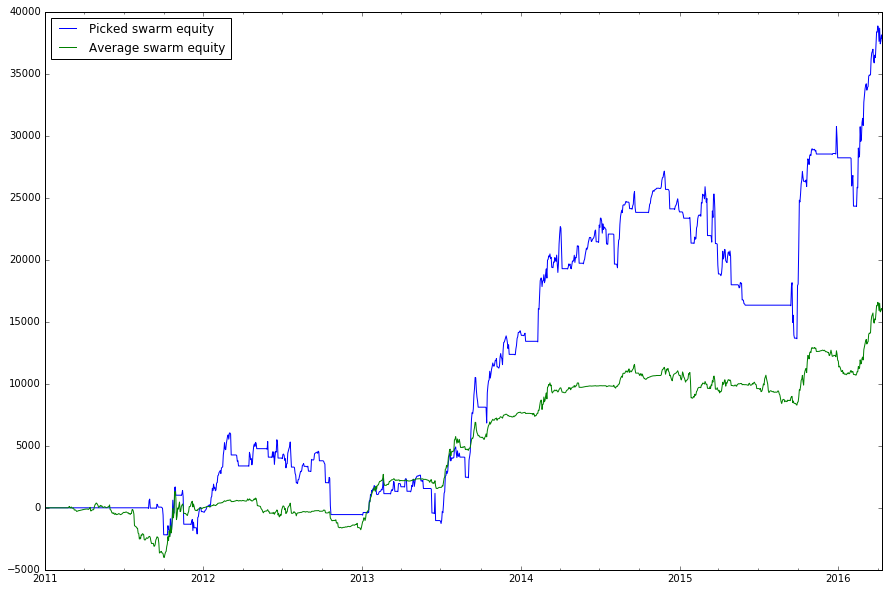

In [15]:
figsize(15,10)
smgr.swarm_picked.sum(axis=1).plot(label='Picked swarm equity');
(smgr.swarm_avg).plot(label='Average swarm equity');
legend(loc=2);


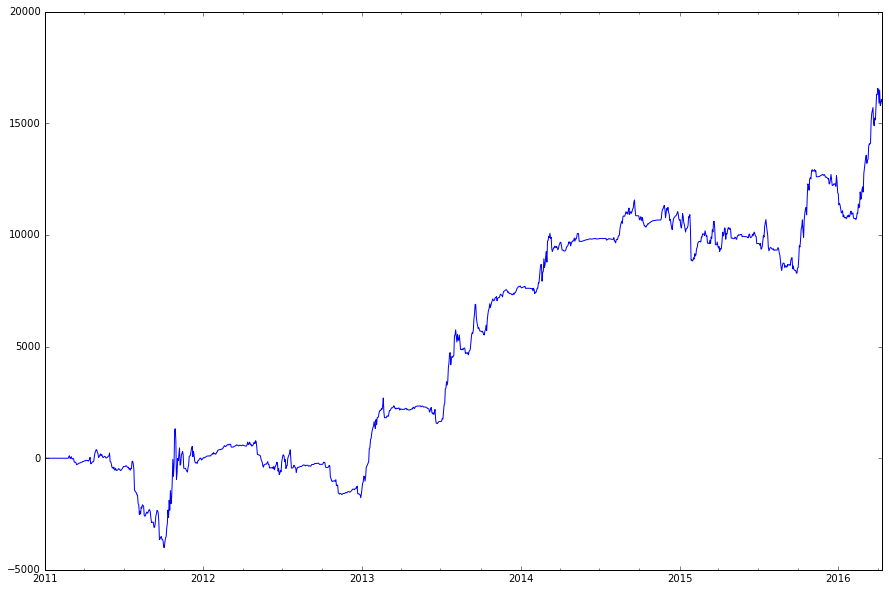

In [11]:
smgr.swarm_avg.plot()

# Swarm statistics

#### Non-picked swarm stats

In [30]:
smgr.get_swarm_stats(smgr.swarm_stats)

{'AvgTradesPerSwarmMember': 25.949999999999999,
 'AvgWinRatePerSwarmMember': 0.45155476907122216,
 'CommissionSum': -51264.0,
 'NetProfit': 492161.0000000014,
 'SwarmMembersCount': 80,
 'TradesCount': 2076.0}

#### Picked swarm stats

In [31]:
smgr.get_swarm_stats(smgr.swarm_picked_stats)

{'AvgTradesPerSwarmMember': 2.2857142857142856,
 'AvgWinRatePerSwarmMember': 0.50595238095238093,
 'CommissionSum': -768.0,
 'NetProfit': 6401.9999999999563,
 'SwarmMembersCount': 14,
 'TradesCount': 32.0}

## Exo information

In [10]:
smgr.strategy.exoinfo.exo_info

{'legs': 4,
 'margin': 3850,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

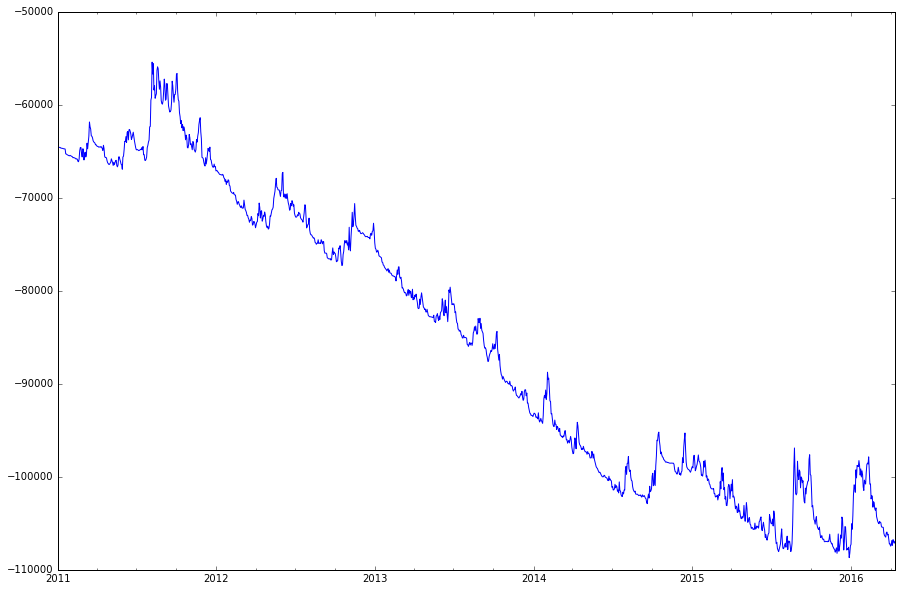

In [11]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information

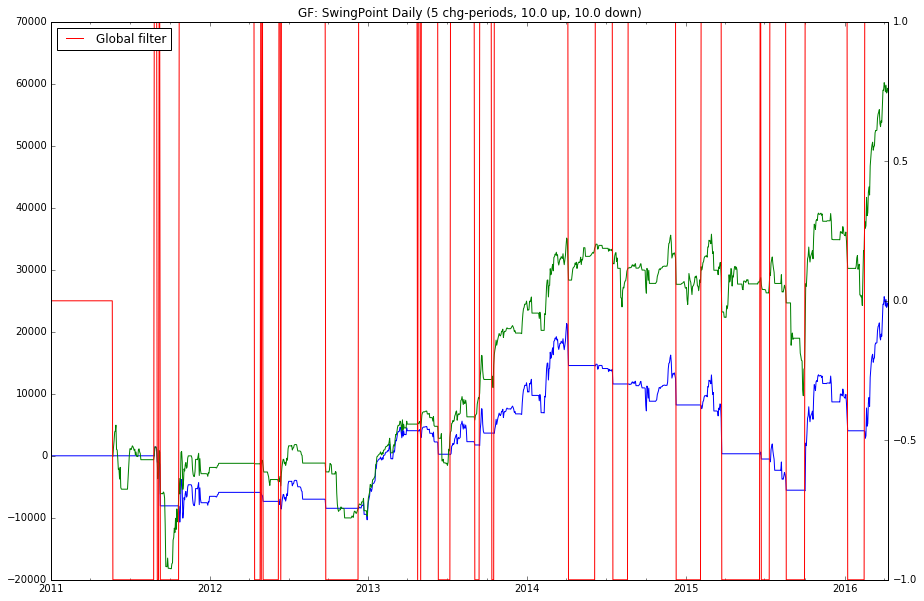

In [12]:
title(smgr.strategy.global_filter_data['name'])
smgr.swarm_picked.sum(axis=1).plot(label='Picked swarm equity with filter')
smgr.strategy.global_filter_data['input_equity'].plot(label='Picked swarm equity without filter (input)')
smgr.strategy.global_filter_data['values'].plot(secondary_y=True, label='Global filter')

legend(loc=2);

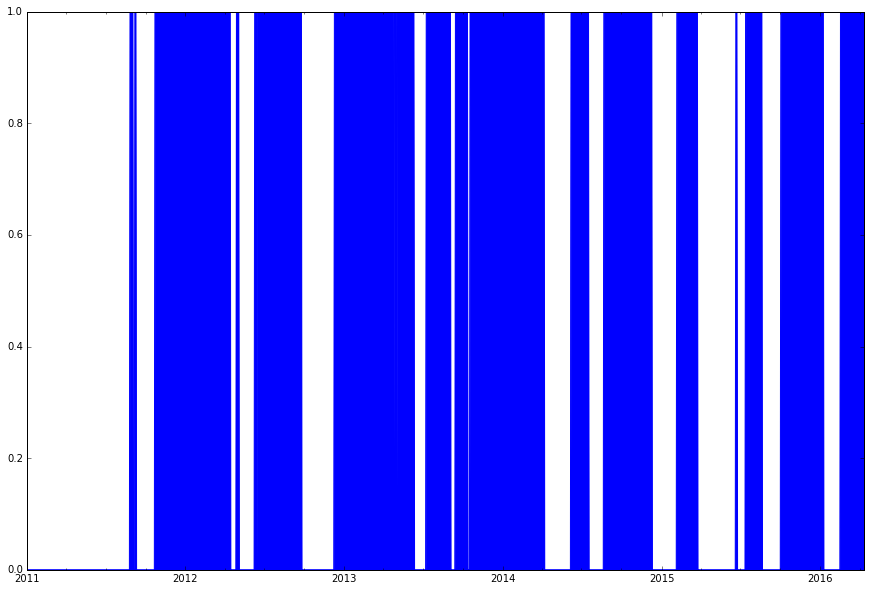

In [13]:
smgr.strategy.global_filter.plot.area()

## Costs information (per 1-exo unit)

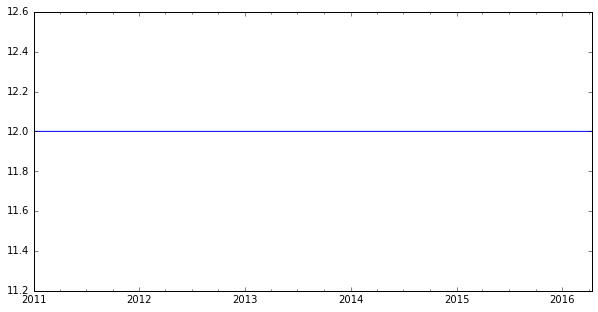

In [14]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

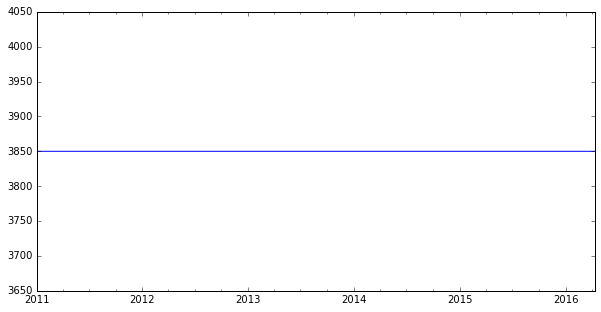

In [15]:
smgr.strategy.exoinfo.margin().plot()

### Average swarm margin

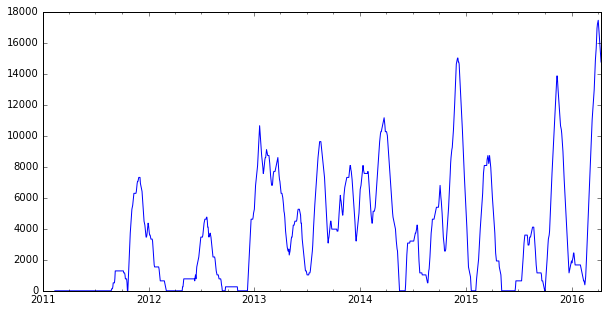

In [16]:
(smgr.swarm_picked_margin).rolling(30).mean().plot()